In [14]:
from rosbags.rosbag2 import Reader, Writer
from rosbags.serde import deserialize_cdr, serialize_cdr
from rosbags.typesys import get_types_from_msg, register_types


from pathlib import Path
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from copy import copy, deepcopy

import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pygeodesy
import math


In [15]:
def guess_msgtype(path: Path) -> str:
    """Guess message type name from path."""
    name = path.relative_to(path.parents[2]).with_suffix('')
    if 'msg' not in name.parts:
        name = name.parent / 'msg' / name.name
    return str(name)

In [16]:
def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))
    
abs_msg_list = absoluteFilePaths('../novatel_oem7_msgs/msg')
msg_list = os.listdir('../novatel_oem7_msgs/msg')

In [17]:
add_types = {}

for pathstr in abs_msg_list:
    msgpath = Path(pathstr)
    msgdef = msgpath.read_text(encoding='utf-8')
    add_types.update(get_types_from_msg(msgdef, guess_msgtype(msgpath)))

register_types(add_types)

In [18]:
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTPOS as BESTPOS
from rosbags.typesys.types import novatel_oem7_msgs__msg__BESTVEL as BESTVEL
from rosbags.typesys.types import novatel_oem7_msgs__msg__Oem7Header as Oem7Header
from rosbags.typesys.types import nav_msgs__msg__Odometry as Odometry
from rosbags.typesys.types import geometry_msgs__msg__PoseWithCovariance as PoseWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__TwistWithCovariance as TwistWithCovariance
from rosbags.typesys.types import geometry_msgs__msg__Pose as Pose
from rosbags.typesys.types import geometry_msgs__msg__Point as Point
from rosbags.typesys.types import geometry_msgs__msg__Quaternion as Quaternion
from rosbags.typesys.types import geometry_msgs__msg__Twist as Twist
from rosbags.typesys.types import geometry_msgs__msg__Vector3 as Vector3

In [6]:
# Data Paths
raw_datadir = '../../data/RAW_ROSBAG'
parse_datadir = '../../data/LOCAL_ODOM'
teams = ['TUM', 'MIT-PITT-RW', 'KAIST', 'EuroRacing', 'PoliMove', 'Cavalier']


In [7]:
# Open a Bag

data_dir = '../../data'
RAW_DIR = 'RAW_ROSBAG'
ODOM_DIR = 'LOCAL_ODOM'
team_name = os.path.join(data_dir,RAW_DIR)
team_dirs = os.listdir(team_name)
track_path = os.path.join(data_dir,RAW_DIR,team_dirs[1])
tracks = os.listdir(track_path)
bags = os.listdir(os.path.join(track_path,tracks[0]))
bag_dir = os.path.join(track_path,tracks[0],bags[0])



        

In [45]:
def read_bag_file(bag_file, topics, topic_types, start_time, end_time):
    topic_dict = {}
    for topic in topics:
        topic_dict[topic] = []

    # create reader instance and open for reading
    with Reader(bag_file) as reader:

        # messages() accepts connection filters
        connections = [x for x in reader.connections if x.topic in topics]
        for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
            if timestamp*1e-9 < start_time or timestamp*1e-9 > end_time:
                continue
            if connection.msgtype in topic_types:
                msg = deserialize_cdr(rawdata, connection.msgtype)
                topic_dict[connection.topic].append((timestamp,msg))

    return topic_dict

In [20]:
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

In [21]:
def gen_local_odom(gps_messages, vel_messages, track):
    
    from rosbags.typesys.types import nav_msgs__msg__Odometry as Odometry
    from rosbags.typesys.types import geometry_msgs__msg__PoseWithCovariance as PoseWithCovariance
    from rosbags.typesys.types import geometry_msgs__msg__TwistWithCovariance as TwistWithCovariance
    from rosbags.typesys.types import geometry_msgs__msg__Pose as Pose
    from rosbags.typesys.types import geometry_msgs__msg__Point as Point
    from rosbags.typesys.types import geometry_msgs__msg__Quaternion as Quaternion
    from rosbags.typesys.types import geometry_msgs__msg__Twist as Twist
    from rosbags.typesys.types import geometry_msgs__msg__Vector3 as Vector3
    from rosbags.typesys.types import sensor_msgs__msg__NavSatFix as NavSatFix

    deg2rad = math.pi/180.0

    local_odom_arr = []
    if track == 'ims':
        origin = (39.795398310617, -86.23476471193612, 223)
    elif track == 'lvms':
        origin = (36.272371177449344, -115.01030828834901, 594)
    gpsmap = pygeodesy.LocalCartesian(origin[0], origin[1], origin[2])

    prev_pos = [0.0,0.0,0.0]
    prev_time = gps_messages[0][0]-10000

    for ros_time, bestpos in tqdm(gps_messages):

        
        bestvel = None

        ros_time_vel = 0

        # Parse BESTPOS

        ros_header = bestpos.header
        ros_frame  = ros_header.frame_id
        gps_header = bestpos.nov_header
        gps_time   = gps_header.gps_week_milliseconds
        lat        = bestpos.lat
        lon        = bestpos.lon
        hgt        = bestpos.hgt
        lat_stdev  = bestpos.lat_stdev  
        lon_stdev  = bestpos.lon_stdev  
        hgt_stdev  = bestpos.hgt_stdev

        novel = True
        # Find Corresponding BESTVEL
        for time,msg in vel_messages:
            if msg.nov_header.gps_week_milliseconds == gps_time:
                ros_time_vel = time
                bestvel = msg
                novel = False
                break
            if msg.nov_header.gps_week_milliseconds > gps_time:
                break 
        

        # GPS 2 LOCAL CARTESIAN
        local_tuple = gpsmap.forward(lat, lon, hgt)
        if novel:
            heading = math.atan2(local_tuple[1] - prev_pos[1], local_tuple[0] - prev_pos[0])
            hor_speed = (((local_tuple[1] - prev_pos[1])**2+(local_tuple[0] - prev_pos[0])**2)**(0.5))/(ros_time-prev_time)
            # quat    = R.from_euler('z',heading).as_quat()
        else:
            ros_header_v = bestvel.header
            gps_header_v = bestvel.nov_header
            gps_time_v   = gps_header_v.gps_week_milliseconds
            trk_gnd      = bestvel.trk_gnd
            latency      = bestvel.latency
            hor_speed    = bestvel.hor_speed
            ver_speed    = bestvel.ver_speed
            heading      =-trk_gnd*deg2rad
        
        trk_r  = R.from_euler('z',heading)
        quat = (trk_r).as_quat()
        rot_stdev = (math.pi/2*180)

        prev_pos[0] = local_tuple[0]
        prev_pos[1] = local_tuple[1]
        prev_pos[2] = local_tuple[2]
        
        prev_time   =  ros_time
        
        
        ros_header.frame_id = 'map'
        # Populate Odom Message
        gps_to_ramg : np.ndarray = np.eye(4)
        gps_to_ramg[0,3]=-1.606
        maptogps : np.ndarray             = np.eye(4)
        maptogps[0:3,3]                   = np.asarray([local_tuple[0], local_tuple[1], local_tuple[2]])
        maptogps[0:3,0:3]                 = R.from_quat(np.asarray([quat[0], quat[1], quat[2], quat[3]])).as_matrix()
        ramg_pose : np.ndarray            = np.matmul(maptogps, gps_to_ramg)
        ramg_quat : np.ndarray            = R.from_matrix(ramg_pose[0:3,0:3]).as_quat()
        
        
        odom_point   = Point(x=ramg_pose[0,3],y=ramg_pose[1,3],z=ramg_pose[2,3])
        odom_quat    = Quaternion(x=ramg_quat[0],y=ramg_quat[1],z=ramg_quat[2],w=ramg_quat[3])
        linear_vel   = Vector3(x=hor_speed,y=0.0,z=0.0)
        angular_vel  = Vector3(x=0.0,y=0.0,z=0.0)
        odom_pose    = Pose(position=odom_point,orientation=odom_quat)
        odom_twist   = Twist(linear=linear_vel,angular=angular_vel)
        cov_pose     = np.zeros(36)
        cov_pose[0]  = lon_stdev*lon_stdev
        cov_pose[7]  = lat_stdev*lat_stdev
        cov_pose[14] = hgt_stdev*hgt_stdev
        cov_pose[21] = rot_stdev*rot_stdev
        cov_pose[28] = rot_stdev*rot_stdev
        cov_pose[35] = rot_stdev*rot_stdev
        cov_twist    = np.zeros(36)
        cov_twist[0] = .125*.125
        cov_twist[7] = .0025
        cov_twist[14]= .0025
        odom_posec   = PoseWithCovariance(pose=odom_pose,covariance=cov_pose)
        odom_twistc  = TwistWithCovariance(twist=odom_twist,covariance=cov_twist)
        
        local_odom = Odometry(header = ros_header,
                              child_frame_id = 'rear_axle_middle_ground',
                              pose = odom_posec,
                              twist= odom_twistc)

        local_odom_arr.append([ros_time, local_odom, gps_time])

    return local_odom_arr

In [51]:
def nav2odom(gps_messages):

    deg2rad = math.pi/180.0

    local_odom_arr = []
    origin = [39.795398310617, -86.23476471193612, 223]
    gpsmap = pygeodesy.LocalCartesian(origin[0], origin[1], origin[2])

    prev_pos = [0.0,0.0,0.0]
    prev_time = gps_messages[0][0]

    for ros_time, msg in tqdm(gps_messages[1:]):


        bestvel = None

        ros_time_vel = 0

        # Parse NavSatFix

        ros_header = msg.header
        ros_frame  = ros_header.frame_id
        lat        = msg.latitude
        lon        = msg.longitude
        hgt        = msg.altitude
        lat_stdev  = msg.position_covariance[0]
        lon_stdev  = msg.position_covariance[4] 
        hgt_stdev  = msg.position_covariance[8]

        # GPS 2 LOCAL CARTESIAN
        local_tuple = gpsmap.forward(lat, lon, hgt)
        heading = math.atan2(local_tuple[1] - prev_pos[1], local_tuple[0] - prev_pos[0])
        hor_speed = (((local_tuple[1] - prev_pos[1])**2+(local_tuple[0] - prev_pos[0])**2)**(0.5))/(ros_time-prev_time)

        trk_r  = R.from_euler('z',heading)
        quat = (trk_r).as_quat()
        rot_stdev = (math.pi/2*180)
        prev_pos[0] = local_tuple[0]
        prev_pos[1] = local_tuple[1]
        prev_pos[2] = local_tuple[2]
        prev_time   =  ros_time

        ros_header.frame_id = 'map'
        # Populate Odom Message
        gps_to_ramg : np.ndarray = np.eye(4)
        gps_to_ramg[0,3]=-1.606
        maptogps : np.ndarray             = np.eye(4)
        maptogps[0:3,3]                   = np.asarray([local_tuple[0], local_tuple[1], local_tuple[2]])
        maptogps[0:3,0:3]                 = R.from_quat(np.asarray([quat[0], quat[1], quat[2], quat[3]])).as_matrix()
        ramg_pose : np.ndarray            = np.matmul(maptogps, gps_to_ramg)
        ramg_quat : np.ndarray            = R.from_matrix(ramg_pose[0:3,0:3]).as_quat()


        odom_point   = Point(x=ramg_pose[0,3],y=ramg_pose[1,3],z=ramg_pose[2,3])
        odom_quat    = Quaternion(x=ramg_quat[0],y=ramg_quat[1],z=ramg_quat[2],w=ramg_quat[3])
        linear_vel   = Vector3(x=hor_speed,y=0.0,z=0.0)
        angular_vel  = Vector3(x=0.0,y=0.0,z=0.0)
        odom_pose    = Pose(position=odom_point,orientation=odom_quat)
        odom_twist   = Twist(linear=linear_vel,angular=angular_vel)
        cov_pose     = np.zeros(36)
        cov_pose[0]  = lon_stdev*lon_stdev
        cov_pose[7]  = lat_stdev*lat_stdev
        cov_pose[14] = hgt_stdev*hgt_stdev
        cov_pose[21] = rot_stdev*rot_stdev
        cov_pose[28] = rot_stdev*rot_stdev
        cov_pose[35] = rot_stdev*rot_stdev
        cov_twist    = np.zeros(36)
        cov_twist[0] = .125*.125
        cov_twist[7] = .0025
        cov_twist[14]= .0025
        odom_posec   = PoseWithCovariance(pose=odom_pose,covariance=cov_pose)
        odom_twistc  = TwistWithCovariance(twist=odom_twist,covariance=cov_twist)

        local_odom = Odometry(header = ros_header,
                            child_frame_id = 'rear_axle_middle_ground',
                            pose = odom_posec,
                            twist= odom_twistc)

        local_odom_arr.append([ros_time, local_odom])
    return local_odom_arr

In [22]:
def visualize_position(local_odom):
    x_pos = []
    y_pos = []
    time  = []
    for odom in local_odom:
        x_pos.append(odom[1].pose.pose.position.x)
        y_pos.append(odom[1].pose.pose.position.y)
        time.append(odom[0]*1e-9)

    plt.rcParams['figure.figsize'] = [50,25]

    fig, ax = plt.subplots(1, 1)
    ax.plot(time, x_pos, marker='o',color='r',linestyle='-', markersize = 1)
    ax.plot(time, y_pos, marker='o',color='g',linestyle='-', markersize = 1)
    plt.gca().set_aspect('equal', adjustable = 'box')
    plt.title('Time vs Position')
    plt.xlabel('time (s)')
    plt.ylabel('pos (m)')
    plt.show()
    

In [46]:
# TUM IMS-PYLON

ego_path = '../../data/RAW_ROSBAG/EURORACING/IMS/IMS-FAST-100-140/rosbag2/20211023_IMS_final'
topics = ['novatel_btm_id0_gps']
topic_types = ['sensor_msgs/msg/NavSatFix']

start_time = 0.0
end_time = 2635012000.0
ego_data = read_bag_file(ego_path, topics, topic_types, start_time, end_time)


20335it [06:10, 54.87it/s] 


In [52]:
ego_odom = nav2odom(ego_data[topics[0]])

100%|███████████████████████████████████| 20334/20334 [00:03<00:00, 5763.31it/s]


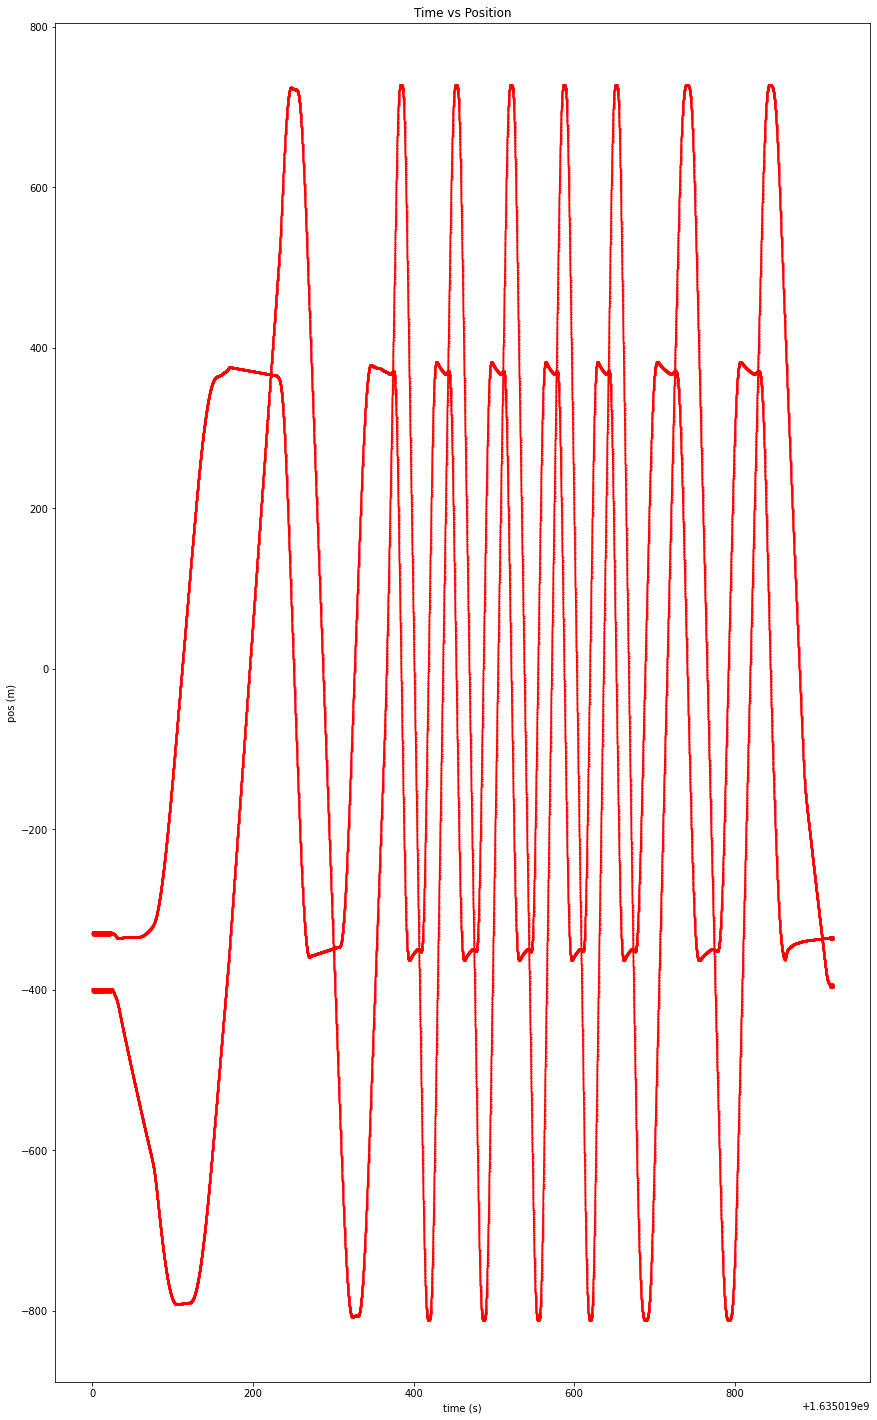

In [54]:
start_time = 1635019000.0
end_time = 2635012000.0
pruned_odom = [ego_odom[i] for i, y in enumerate(ego_odom) if (y[0]*1e-9 > start_time) and (y[0]*1e-9 < end_time)]
cx_pos = []
cy_pos = []
ctime  = []
ptime  = []
for odom in pruned_odom:
    cx_pos.append(odom[1].pose.pose.position.x)
    cy_pos.append(odom[1].pose.pose.position.y)
    ctime.append(odom[0]*1e-9)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(ctime, cx_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(ctime, cy_pos, marker='o',color='r',linestyle='-', markersize = 1)

plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('Time vs Position')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()

In [15]:
mit_namespace = 'vehicle_8'
kaist_namespace = 'vehicle_4'

mit_sensors=[]
conn_map = {}
with Reader(mit_bag_file) as reader, Writer('../../data/MERGED/MIT-PITT-RW/LVMS/MS_KAIST') as writer:
    for connection in reader.connections:
        if (connection.topic == '/tf') or (connection.topic == '/tf_static'):
            continue
        mit_sensors.append(connection.topic)
        conn_map[connection.id] = writer.add_connection('/{}{}'.format(mit_namespace,connection.topic), connection.msgtype, 'cdr', '')

    connections = [x for x in reader.connections if x.topic in mit_sensors]
    for connection, timestamp, rawdata in tqdm(reader.messages(connections=connections)):
        if ((timestamp*1e-9 > 1641163600.0) and timestamp*1e-9 < 1641164300.0):
            writer.write(conn_map[connection.id], timestamp, rawdata)
    
        
    # add new connection
    topic = '/vehicle_8/local_odometry'
    mit_msgtype = Odometry.__msgtype__
    mit_connection = writer.add_connection(topic, mit_msgtype, 'cdr', '')

    topic = '/vehicle_4/local_odometry'
    kaist_msgtype = Odometry.__msgtype__
    kaist_connection = writer.add_connection(topic, kaist_msgtype, 'cdr', '')
    
    for odom in pruned_mit_odom:
        timestamp = odom[0]
        message = odom[1]
        writer.write(mit_connection, timestamp, serialize_cdr(message,mit_msgtype))
    for odom in pruned_kaist_odom:
        timestamp = odom[0]
        message = odom[1]
        writer.write(kaist_connection, timestamp, serialize_cdr(message,kaist_msgtype))

8574309it [02:01, 70715.93it/s] 


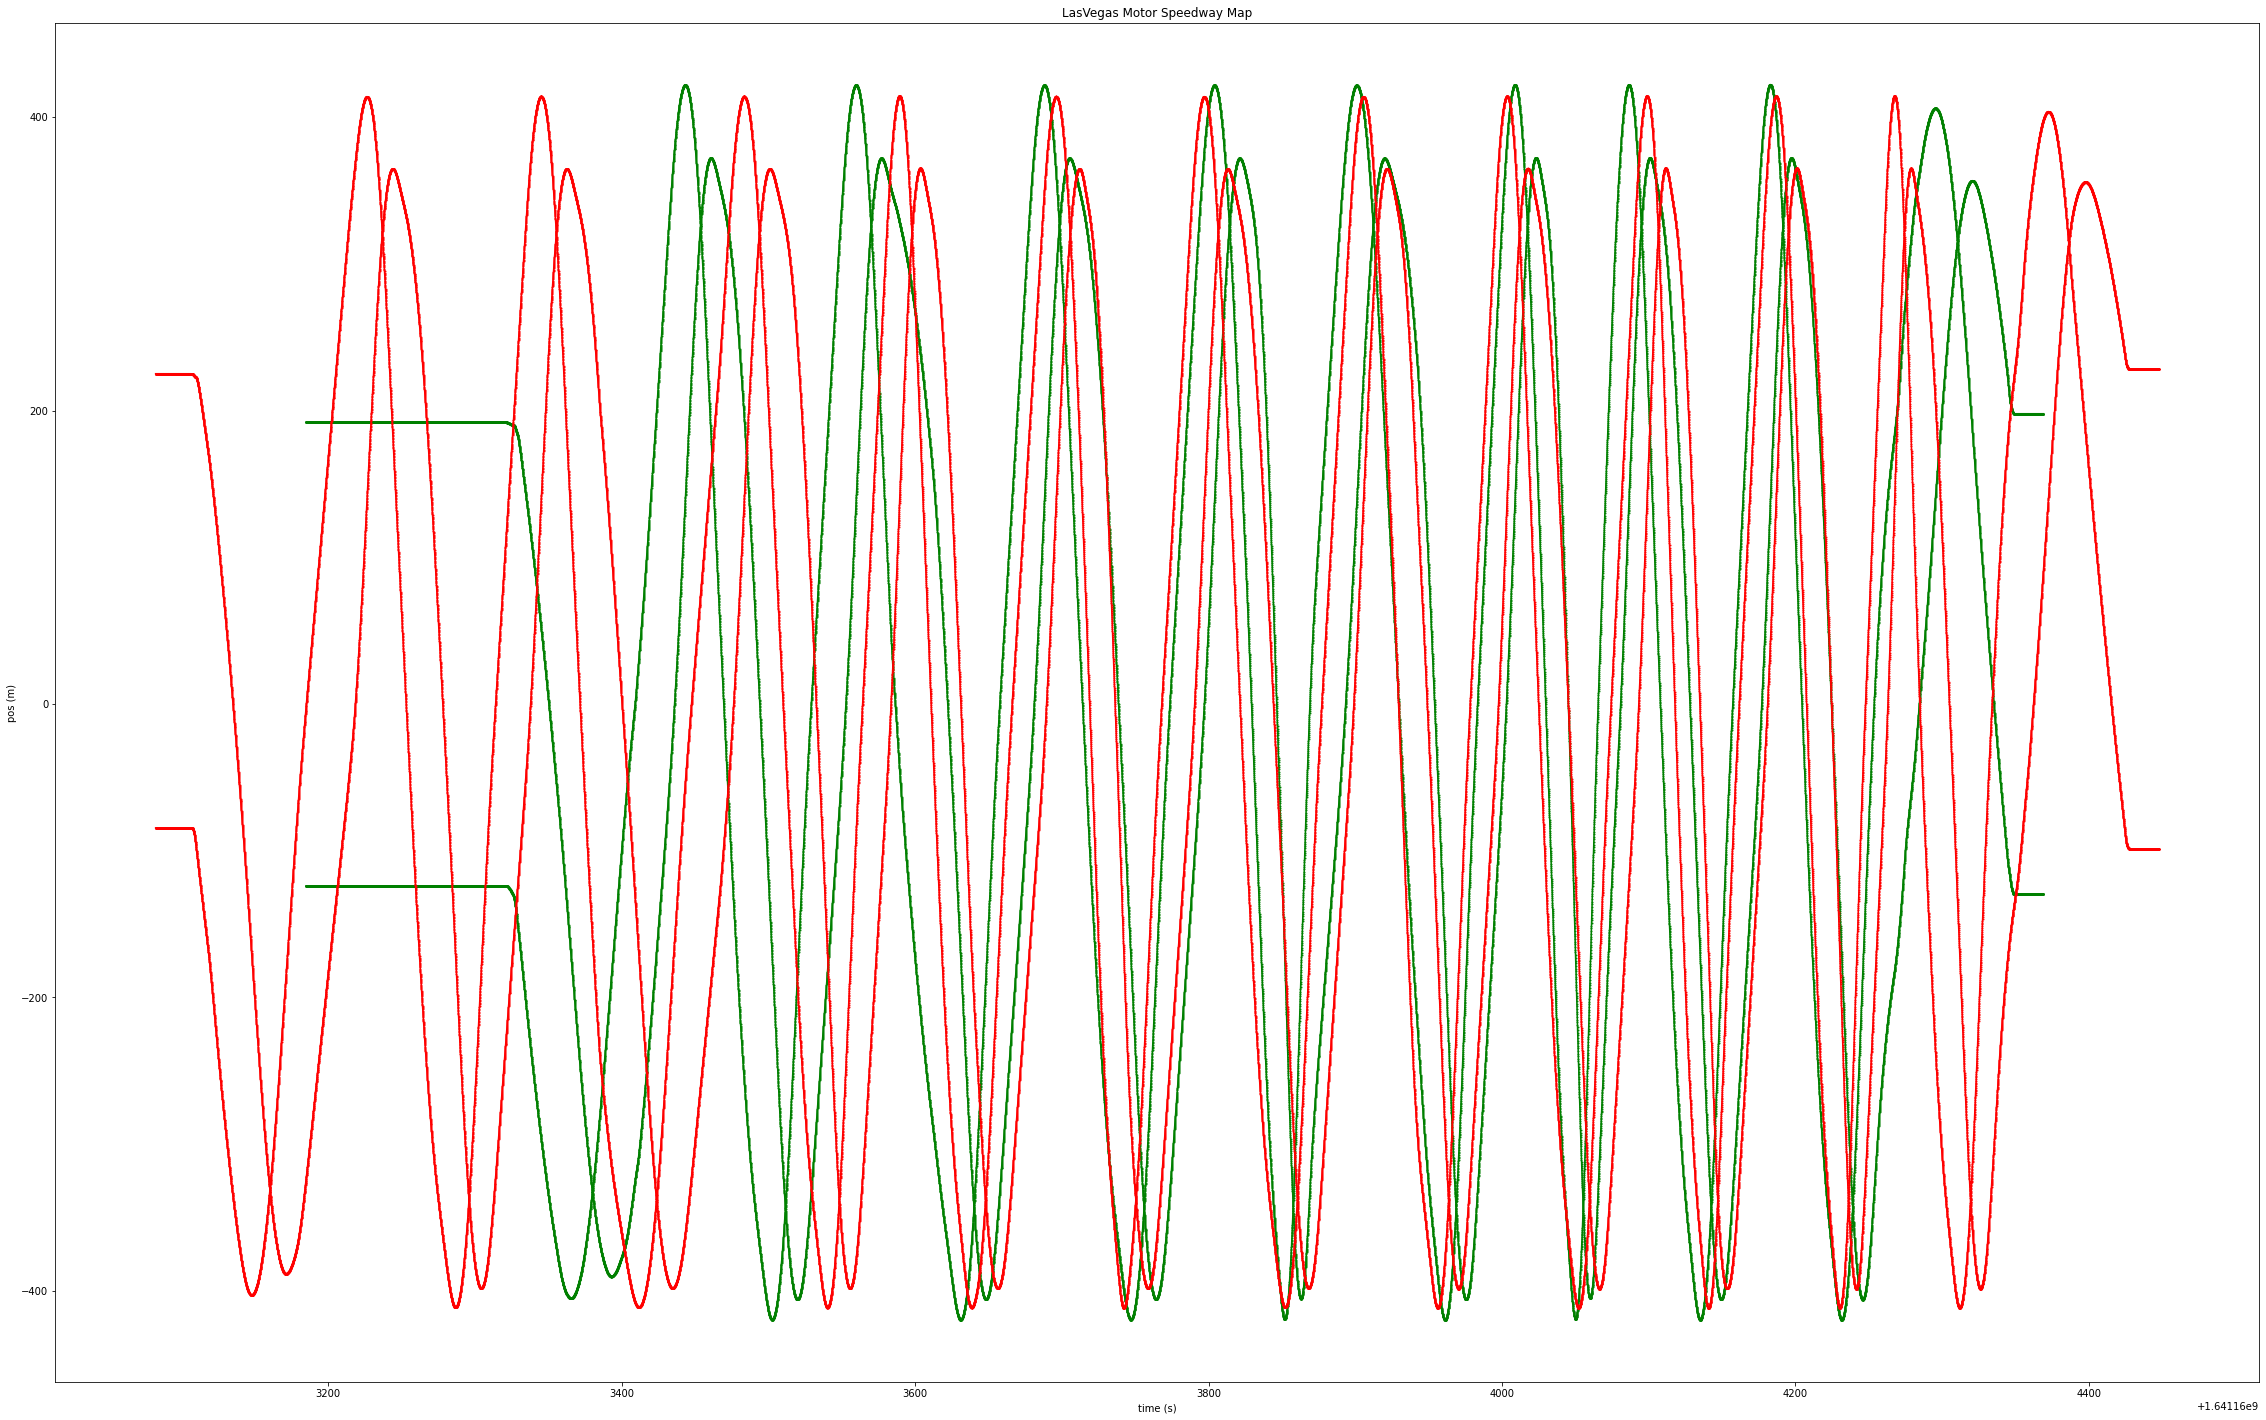

In [24]:
mit_x_pos = []
mit_y_pos = []
mit_time  = []
for odom in mit_local_odom:
    mit_x_pos.append(odom[1].pose.pose.position.x)
    mit_y_pos.append(odom[1].pose.pose.position.y)
    mit_time.append(odom[0]*1e-9)

mit_x_pos = np.asarray(mit_x_pos)
mit_y_pos = np.asarray(mit_y_pos)
mit_time  = np.asarray(mit_time)

kaist_x_pos = []
kaist_y_pos = []
kaist_time  = []
for odom in kaist_local_odom:
    kaist_x_pos.append(odom[1].pose.pose.position.x)
    kaist_y_pos.append(odom[1].pose.pose.position.y)
    kaist_time.append(odom[0]*1e-9)

kaist_x_pos = np.asarray(kaist_x_pos)
kaist_y_pos = np.asarray(kaist_y_pos)
kaist_time = np.asarray(kaist_time)

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(kaist_time, kaist_x_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(kaist_time, kaist_y_pos, marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(mit_time, mit_x_pos, marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(mit_time, mit_y_pos, marker='o',color='r',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('LasVegas Motor Speedway Map')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()



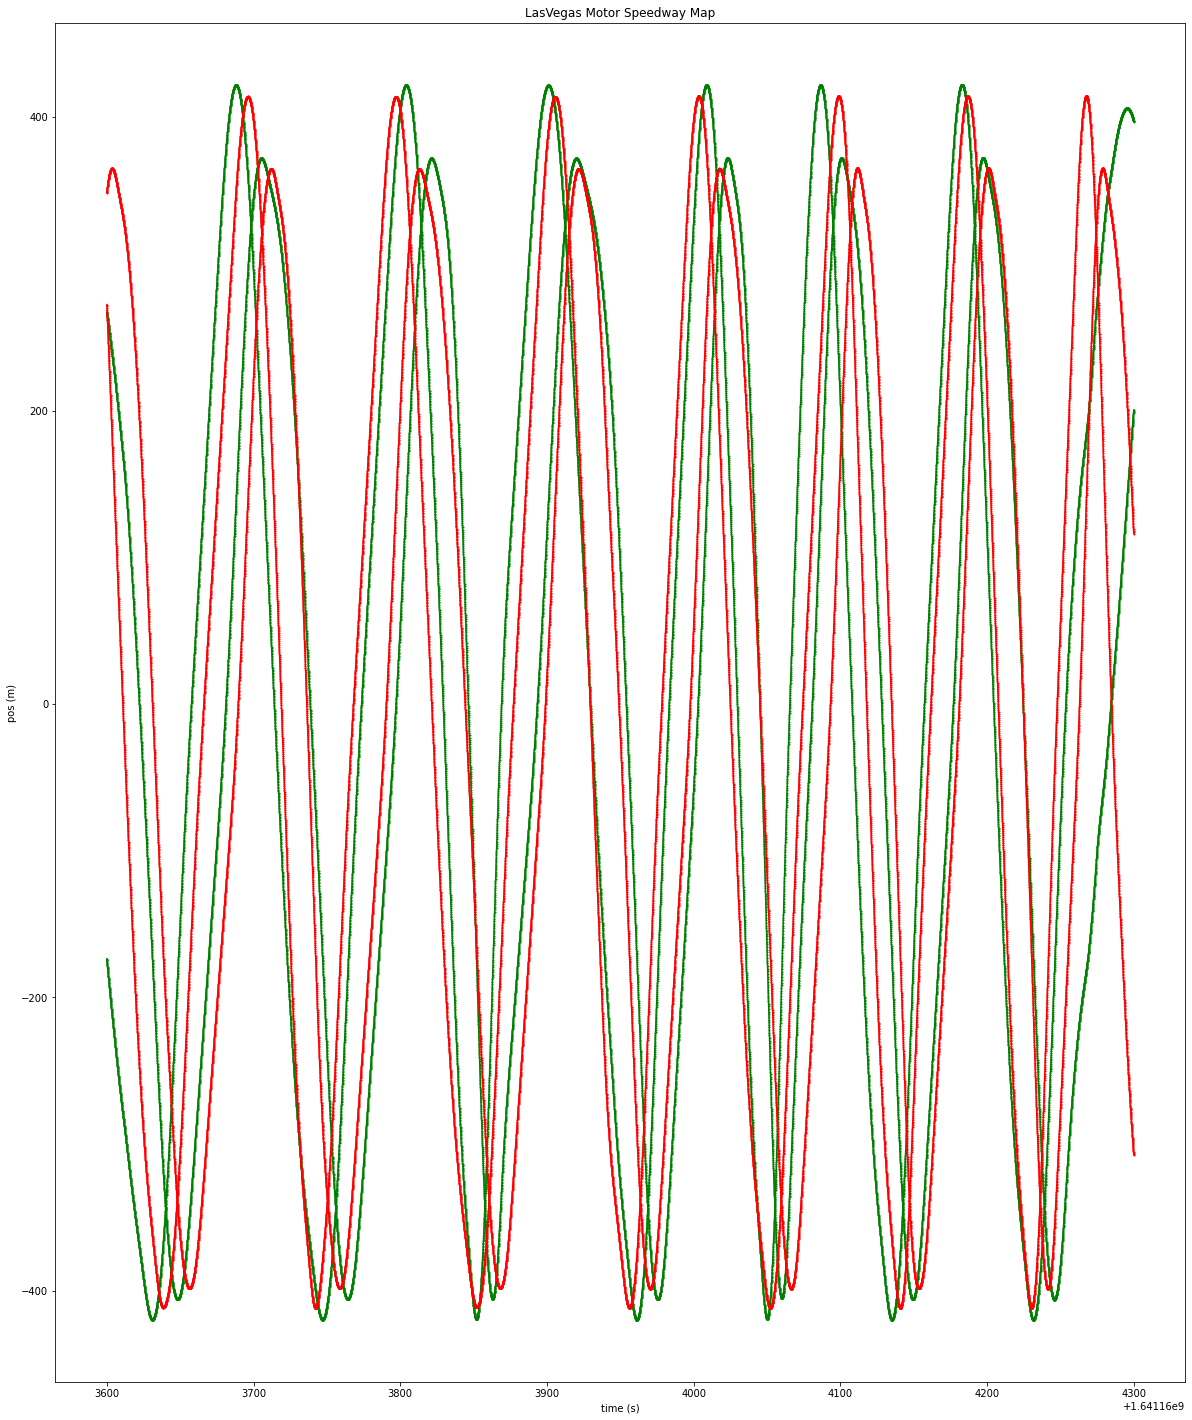

In [38]:
pruned_kaist_1 = np.argwhere(kaist_time > 1641163600.0).tolist()
pruned_kaist_2 = np.argwhere(1641164300.0 > kaist_time).tolist()

pruned_mit_1 = np.argwhere(mit_time > 1641163600.0).tolist()
pruned_mit_2 = np.argwhere(1641164300.0 > mit_time).tolist()

k1 = pruned_kaist_1[0][0]
k2 = pruned_kaist_2[-1][0]
m1 = pruned_mit_1[0][0]
m2 = pruned_mit_2[-1][0]

plt.rcParams['figure.figsize'] = [50,25]

fig, ax = plt.subplots(1, 1)
ax.plot(kaist_time[k1:k2], kaist_x_pos[k1:k2], marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(kaist_time[k1:k2], kaist_y_pos[k1:k2], marker='o',color='g',linestyle='-', markersize = 1)
ax.plot(mit_time[m1:m2], mit_x_pos[m1:m2], marker='o',color='r',linestyle='-', markersize = 1)
ax.plot(mit_time[m1:m2], mit_y_pos[m1:m2], marker='o',color='r',linestyle='-', markersize = 1)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.title('LasVegas Motor Speedway Map')
plt.xlabel('time (s)')
plt.ylabel('pos (m)')
plt.show()